In [1]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import utils.utils as utils
import utils.dataloader_utils as dataloader_utils
import utils.train_utils as train_utils

import json
from tqdm import tqdm
import gc
from copy import deepcopy

%load_ext autoreload
%autoreload 2

2022-11-05 23:13:11.472653: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 23:13:11.579460: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-05 23:13:11.945170: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/noetic/lib:/usr/local/cuda-11.8/lib64:/usr/lib/cuda/lib64
2022-11-05 23:13:11.945212: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.

In [2]:
np.__version__

'1.23.3'

In [3]:
tf.config.experimental.list_physical_devices('GPU')

2022-11-05 23:13:13.298670: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 23:13:13.319419: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 23:13:13.319600: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tfp.__version__, tf.__version__

('0.18.0', '2.10.0')

# Load Data

In [13]:
BATCH_SIZE = 1024
num_points_in_one_traj = 51
object_type = 'cyclist' #

In [14]:
if object_type == 'vehicle':
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_select_non_outlier_indicies.json', "r") as read_file:
        idx_trajs_select = json.load(read_file)

    list_dataset = dataloader_utils.generate_selected_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_trajs_select)
    start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json')
    combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))
else:
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_outlier_indicies.json', "r") as read_file:
        idx_outlier = json.load(read_file)
        
    list_dataset = dataloader_utils.generate_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_outlier)
    start_idx_dataset = dataloader_utils.generate_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json', idx_outlier)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type = 'agt_traj')
dataProcessor.load_process(shuffle = False)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████████████████████████████| 62785/62785 [00:06<00:00, 10115.43it/s]
2022-11-05 22:10:46.041341: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 22:10:46.042096: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 22:10:46.042217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 22:10:46.042299: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative

tf.Tensor(46, shape=(), dtype=int64)


found
(689, 81) (689, 162) (689, 81) (689, 81) (689, 81, 2, 2)


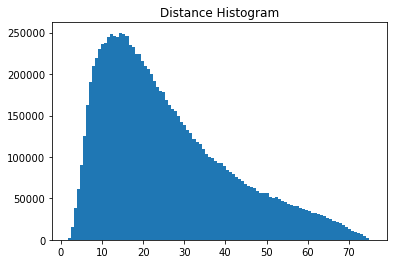

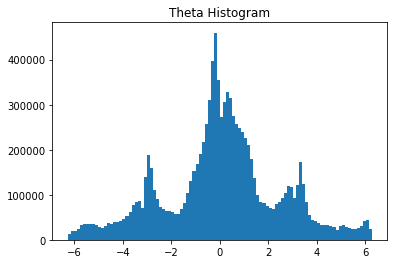

In [17]:
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

d_all = np.zeros((list_dataset.__len__(), num_points_in_one_traj))
theta_all = np.zeros((list_dataset.__len__(), num_points_in_one_traj))    
    
start_idx = 0

for times, agt_traj, d_norm, theta, R_ego_to_map in dataProcessor.loaded_dataset:
    batch_size = times.shape[0]    
    d_all[start_idx:start_idx+batch_size] = d_norm
    theta_all[start_idx:start_idx+batch_size] = theta
    start_idx = start_idx+batch_size
    
    
    
ax1.hist(d_all.reshape(-1), bins = 100)
ax1.set_title('Distance Histogram')
ax2.hist(theta_all.reshape(-1), bins = 100)
ax2.set_title('Theta Histogram')
print(times.shape, agt_traj.shape, d_norm.shape, theta.shape, R_ego_to_map.shape)

In [ ]:
from matplotlib.patches import Ellipse
from scipy.special import binom
from scipy.stats.distributions import chi2
def draw_confidence_ellipse(mean, cov, ax, **kwarg):
    d,u = np.linalg.eigh(cov)
    
    confidence = chi2.ppf(0.95,2)
    height, width = 2*np.sqrt(confidence*d)
    angle = np.degrees(np.arctan2(u[1,-1], u[0,-1]))
    
    ax.scatter(*mean, s=100, marker='x', **kwarg)
    
    ellipse = Ellipse(
        xy=mean, 
        width=width, 
        height=height, 
        angle = angle,
        fill = False,
        **kwarg
    )
    
    ax.add_artist(ellipse)

In [36]:
if object_type == 'vehicle':
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_select_non_outlier_indicies.json', "r") as read_file:
        idx_trajs_select = json.load(read_file)

    list_dataset = dataloader_utils.generate_selected_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_trajs_select)
    start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json')
    combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))
else:
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_outlier_indicies.json', "r") as read_file:
        idx_outlier = json.load(read_file)
        
    list_dataset = dataloader_utils.generate_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_outlier)
    start_idx_dataset = dataloader_utils.generate_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json', idx_outlier)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type = 'agt_traj')
dataProcessor.load_process_test(shuffle = False)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████| 300000/300000 [00:00<00:00, 552525.99it/s]


tf.Tensor(293, shape=(), dtype=int64)


In [21]:
for times, agt_traj, ego_traj, d_norm, R in dataProcessor.loaded_dataset:
    batch_size = times.shape[0]    
    break

In [22]:
sample_idx = 10
time_sample = times[sample_idx]
agt_traj_sample = agt_traj[sample_idx]
ego_traj_sample = ego_traj[sample_idx]
d_sample = d_norm[sample_idx]
R_sample = R[sample_idx]
B_lon = np.array([0.05, 0.05, 0.005])[:, None]
B_lat = np.array([0.01, 0.01, 0.001])[:, None]

In [23]:
phi_d = utils.expand(d_sample, bf=utils.polynomial_basis_function, bf_args=range(1, 2+1))
var_lon = phi_d@B_lon
var_lat = phi_d@B_lat

cov = tf.linalg.diag(tf.concat([var_lon, var_lat], axis = 1)).numpy()
cov_rotated = R_sample @ cov @ np.transpose(R_sample, (0,2,1))

In [25]:
R_sample.shape, cov.shape

(TensorShape([51, 2, 2]), (51, 2, 2))

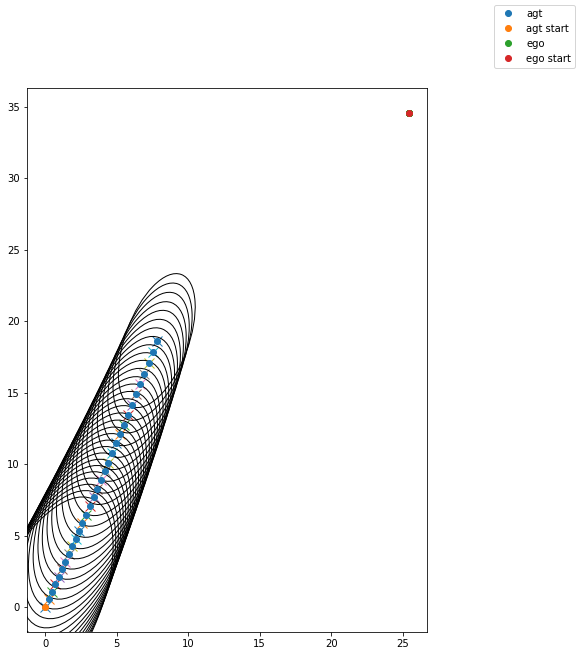

In [113]:
fig, ax = plt.subplots(figsize = (10,10))
ax.plot(agt_traj_sample[:num_points_in_one_traj], agt_traj_sample[num_points_in_one_traj:], 'o', label = "agt")
ax.plot(agt_traj_sample[0], agt_traj_sample[num_points_in_one_traj], 'o', label = "agt start")
ax.plot(ego_traj_sample[:num_points_in_one_traj], ego_traj_sample[num_points_in_one_traj:], 'o', label = "ego")
ax.plot(ego_traj_sample[0], ego_traj_sample[num_points_in_one_traj], 'o', label = "ego start")

for i, c in enumerate(cov_rotated):
    draw_confidence_ellipse([agt_traj_sample[i],agt_traj_sample[i+num_points_in_one_traj]], c, ax, linewidth = 1)
fig.legend()
ax.set_aspect('equal')

# Training

In [7]:
EPOCHS = 1
lr = 5e-3

In [8]:
losses = []
best_losses = []
best_epoch_losses = []
best_epochs = []
bic_scores = []
aic_scores = []
A_list, B_list = [], []
optimizers_ser = []
t_scale_factor = (num_points_in_one_traj-1) / 10 # The time duration of one trajectory, for scaling time to interval (0,1)
log_root_dir = 'logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + 'test'
nan_batches = []
degrees = np.linspace(1, 8, 8, dtype=np.int16) # Analyse polynomials from degree 1 to 8
#degrees = [7]
for i_d, deg in enumerate(degrees):
    print('Trainig deg ',deg)
    model_losses = []
    
    # Initialize optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)   
    optimizers_ser.append(tf.keras.optimizers.serialize(optimizer))
    
    # Initialize all trainable variables
    A = tf.Variable(np.random.randn(2*(deg), 2*(deg))*1e-1, dtype=tf.float64, name='alpha') # Model uncertainty
    B_d = tf.Variable(np.random.randn(3, 1), dtype=tf.float64, name='beta_d') 
    B_theta = tf.Variable(np.random.randn(1), dtype=tf.float64, name='beta_theta')
    B_const =  tf.Variable(np.random.randn(1), dtype=tf.float64, name='beta_const')
    
    # Initialize tf summary writer
    train_log_dir = log_root_dir + '/deg_' + str(deg)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
    
    # Start Training
    best_epoch_loss, best_epoch, best_alpha, best_beta_d, best_beta_theta, best_beta_const = train_utils.train_agt(alpha=A, beta_d=B_d, beta_theta=B_theta, beta_const = B_const, t_scale_factor = t_scale_factor, degree = deg,
                                                                                                                   opti=optimizer, epochs = EPOCHS, data_loader=dataProcessor.loaded_dataset, model_losses = model_losses, 
                                                                                                                   tf_summary_writer = train_summary_writer, verbose = True, early_stop=False)
            
    # Add loss
    losses.append(model_losses)
    best_epoch_losses.append([best_epoch_loss])
    
    # store the best epoch
    best_epochs.append(best_epoch)
    
    # Compute AIC and BIC
    aic_score, bic_score = utils.compute_AIC_BIC(nll = best_epoch_loss, deg = deg, num_points = num_points_in_one_traj)

    bic_scores.append(bic_score)
    aic_scores.append(aic_score)
    
    # Compute the model uncertainty, A_unscaled = np.linalg.inv(scale_mat) @ A_scaled
    A_scale_mat = utils.polyBasisScale(t_scale_factor, deg)
    A_scale_mat = A_scale_mat[1:, 1:]
    A_est = np.linalg.inv(np.kron(np.eye(2), A_scale_mat)) @ best_alpha.numpy()
    A_est = A_est @ A_est.T # This is the unscaled model parameter covariance
    A_list.append(A_est)
    
    # Compute the observation uncertainty and store
    B_est = {'B_d': (tf.math.softplus(best_beta_d)).numpy(), 'B_theta': (tf.math.softplus(best_beta_theta)).numpy(),'B_const': (tf.math.softplus(best_beta_const)).numpy()}
    B_list.append(B_est)
    print(deg, model_losses[-1], bic_score, aic_score)

Trainig deg  1


100%|██████████| 1/1 [00:40<00:00, 40.57s/it]


Epoch  0 , Loss:  257.8051787966857
1 257.8051787966857 266.3901468078986 262.8051787966857
Trainig deg  2


100%|██████████| 1/1 [00:41<00:00, 41.38s/it]


Epoch  0 , Loss:  240.70338515924982
2 240.70338515924982 261.3073083861607 252.70338515924982
Trainig deg  3


100%|██████████| 1/1 [00:40<00:00, 40.09s/it]


Epoch  0 , Loss:  233.07597305631188
3 233.07597305631188 272.5668259078911 256.0759730563119
Trainig deg  4


  0%|          | 0/1 [00:29<?, ?it/s]


KeyboardInterrupt: 

In [39]:
result = utils.calculate_result(degrees, bic_scores, aic_scores, A_list, B_list, best_epoch_losses, best_epochs, lr, optimizers_ser, EPOCHS, BATCH_SIZE)

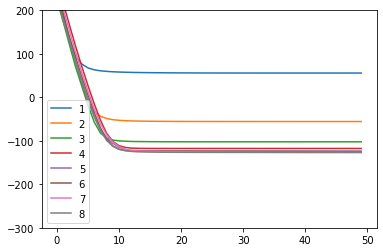

In [40]:
fig,ax = utils.plot_losses(losses, degrees = degrees, y_lim=[-300, 200])
fig.savefig('imgs/agt_polar_' + str(num_points_in_one_traj) + '.svg')

In [41]:
result['best_aic_A']

array([[ 3.94339629e+01,  1.16404827e-02, -9.29584282e-02,
         7.41671924e-03, -1.08149368e+00,  1.61152348e-01,
        -2.71617750e-03, -2.29815780e-03],
       [ 1.16404827e-02,  4.17862715e-01, -8.69220593e-02,
         9.17814406e-03, -1.89623895e-01,  9.42947231e-04,
         6.54669718e-03, -7.63638853e-04],
       [-9.29584282e-02, -8.69220593e-02,  5.44648143e-02,
        -8.02327579e-03, -1.21727809e-03, -5.29639190e-03,
        -5.02553850e-04,  1.64431398e-04],
       [ 7.41671924e-03,  9.17814406e-03, -8.02327579e-03,
         1.36162456e-03,  2.09353081e-03,  5.67036122e-04,
        -2.78058429e-05, -7.16999214e-06],
       [-1.08149368e+00, -1.89623895e-01, -1.21727809e-03,
         2.09353081e-03,  4.36133058e+01, -5.98540043e-02,
        -1.00160283e-01,  9.38994870e-03],
       [ 1.61152348e-01,  9.42947231e-04, -5.29639190e-03,
         5.67036122e-04, -5.98540043e-02,  4.65916147e-01,
        -9.68304337e-02,  1.02888372e-02],
       [-2.71617750e-03,  6.546697

In [42]:
result['best_aic_B']

{'B_d': array([[5.91219464e-05],
        [4.20220285e-06],
        [6.35112276e-07]]),
 'B_theta': array([1.13355014e-07]),
 'B_const': array([0.0001483])}

In [43]:
utils.save_result(folder_dir =log_root_dir, file_name='result_summary', result=result)
with open(log_root_dir + '/' + 'lr_schedules' + '.json', "w") as write_file:
    json.dump(lr_schedules_ser, write_file, cls=NumpyEncoder)
with open(log_root_dir + '/' + 'optimizers' + '.json', "w") as write_file:
    json.dump(optimizers_ser, write_file, cls=NumpyEncoder)

Text(0, 0.5, '[m]')

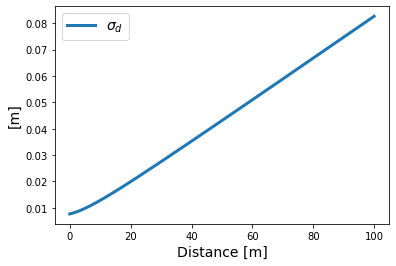

In [45]:
fig, ax = plt.subplots()
d = np.linspace(0, 100, 1000)
theta = 0
sigmas_d = []

#wd = (tf.math.softplus(B_d)).numpy()
wd = (result['best_aic_B']['B_d'])
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_d.append(sigma)
ax.plot(d, sigmas_d, label = '${\sigma}_{d}$', linewidth = 3)  
ax.legend(fontsize=14)
ax.set_xlabel("Distance [m]", fontsize=14)
ax.set_ylabel("[m]", fontsize=14)

Text(0, 0.5, '(m)')

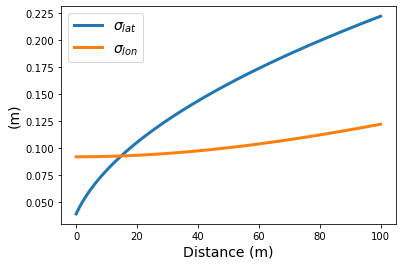

In [152]:
fig, ax = plt.subplots()
d = np.linspace(0, 100, 1000)
sigmas_lat = []
sigmas_lon = []
wd = np.array(result['best_aic_B']['B_lat'])
#wd = tf.math.softplus(best_beta_lat)
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_lat.append(sigma)
ax.plot(d, sigmas_lat, label = '${\sigma}_{lat}$', linewidth = 3)  


wd = np.array(result['best_aic_B']['B_lon'])
#wd = tf.math.softplus(best_beta_lon)
for d_i in d:
    sigma = np.sqrt(wd[0] + wd[1]*d_i + wd[2]* (d_i**2))
    sigmas_lon.append(sigma)
    

ax.plot(d, sigmas_lon, label = '${\sigma}_{lon}$', linewidth = 3) 
ax.legend(fontsize=14)
ax.set_xlabel("Distance (m)", fontsize=14)
ax.set_ylabel("(m)", fontsize=14)

# Dummy Code

In [20]:
num_points_in_one_traj = 91
deg_to_change = 7
idx_to_change = deg_to_change-1
with open('logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + '/result_summary.json', "r") as read_file:
    result_old = json.load(read_file)
          
with open('logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + '_only_' + str(deg_to_change) + 'th/result_summary.json', "r") as read_file:
    result_sub = json.load(read_file)

In [21]:
result_old['losses'][idx_to_change] = result_sub['losses'][0]
result_old['A_list'][idx_to_change] = result_sub['A_list'][0]
result_old['B_list'][idx_to_change] = result_sub['B_list'][0]

result_old['lr'][idx_to_change] = result_sub['lr'][0]
result_old['optimizer'][idx_to_change] = result_sub['optimizer'][0]

result_old['bic_scores'][idx_to_change] = result_sub['bic_scores'][0]
best_bic_deg_idx = np.where(result_old['bic_scores'] == np.amin(result_old['bic_scores']))[0][0]
result_old['best_bic'] = result_old['bic_scores'][best_bic_deg_idx]
result_old['best_bic_A'] = result_old['A_list'][best_bic_deg_idx]
result_old['best_bic_B'] = result_old['B_list'][best_bic_deg_idx]
result_old['best_bic_deg'] = result_old['degree'][best_bic_deg_idx]
result_old['best_bic_deg_idx'] = best_bic_deg_idx


result_old['aic_scores'][idx_to_change] = result_sub['aic_scores'][0]
best_aic_deg_idx = np.where(result_old['aic_scores'] == np.amin(result_old['aic_scores']))[0][0]
result_old['best_aic'] = result_old['aic_scores'][best_aic_deg_idx]
result_old['best_aic_A'] = result_old['A_list'][best_aic_deg_idx]
result_old['best_aic_B'] = result_old['B_list'][best_aic_deg_idx]
result_old['best_aic_deg'] = result_old['degree'][best_aic_deg_idx]
result_old['best_aic_deg_idx'] = best_aic_deg_idx

with open('logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + '/result_summary_new.json', "w") as write_file:
    json.dump(result_old, write_file, cls=NumpyEncoder)

# Dummy Code

In [5]:
BATCH_SIZE = 256
num_points_in_one_traj = 51
object_type = 'cyclist' #

In [6]:
if object_type == 'vehicle':
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_select_non_outlier_indicies.json', "r") as read_file:
        idx_trajs_select = json.load(read_file)

    list_dataset = dataloader_utils.generate_selected_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_trajs_select)
    start_idx_dataset = dataloader_utils.generate_selected_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json')
    combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))
else:
    with open('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_outlier_indicies.json', "r") as read_file:
        idx_outlier = json.load(read_file)
        
    list_dataset = dataloader_utils.generate_file_list_dataset('data/' + object_type + '/agt_trajs_json/', idx_outlier)
    start_idx_dataset = dataloader_utils.generate_start_indicies_dataset('data/' + object_type + '/agt_trajs_' + str(num_points_in_one_traj) + '_json/agt_trajs_start_point_indicies.json', idx_outlier)

combined_dataset = tf.data.Dataset.zip((list_dataset, start_idx_dataset))

dataProcessor = dataloader_utils.DataProcessor(BATCH_SIZE, combined_dataset, num_points_in_one_traj, traj_type = 'agt_traj')
dataProcessor.load_process_test(shuffle = True)

print(dataProcessor.loaded_dataset.__len__())

100%|██████████████████████████████████| 62785/62785 [00:06<00:00, 10002.02it/s]
2022-11-05 23:13:35.946002: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-05 23:13:35.946537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 23:13:35.946665: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-05 23:13:35.946751: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative

tf.Tensor(183, shape=(), dtype=int64)


In [7]:
EPOCHS = 50
lr = 5e-3

In [8]:
def build_agt_mvn(alpha, beta_lon, beta_lat, phi_t, phi_d, R, num_points):
    '''
    build multivariate normal distribution for agt trajectory batch. 
    Covariance from polar to cartesian according to p77 in "N. Kämpchen, “Feature-level fusion of laser scannerand video data for advanced driver assistance systems, 
    Ph.D. dissertation, Universität Ulm, 2007.”

    Inputs:
        alpha: trainable variable for model parameter covariance
        beta_d: trainable variable for distance variance in polar coodinate. dim: (3, 1)
        beta_theta: trainable variable for angular variance in polar coordinate
        beta_const: trainable variable for base variance in ego cartesian coordinate
        phi_t: batch-wise basis function of time
        phi_d: batch-wise basis function of agent distance in polar frame
        d_norm: euclidian distance between ego and agent
        theta: angle in polar frame
        R: Rotation matrix from ego frame to world frame
        num_points: number of sample points in one trajectory
    Outputs:
        tf distribution
    '''
    def mvn_agt(alpha, beta_lon, beta_lat, phi_t, phi_d, R):      
        var_lon = tf.squeeze(phi_d@tf.math.softplus(beta_lon))
        var_lat = tf.squeeze(phi_d@tf.math.softplus(beta_lat))

        B = tf.linalg.diag(tf.concat([var_lon, var_lat], axis = 1))
        
        cov = R @ B @ tf.transpose(R, perm=[0, 2, 1]) + (phi_t @ alpha )  @ (tf.transpose(phi_t @ alpha, perm=[0, 2, 1]))
        
        return tfd.MultivariateNormalTriL(loc=tf.zeros((2* num_points), dtype = tf.float64), scale_tril=tf.linalg.cholesky(cov))

    
    return tfp.experimental.util.DeferredModule(build_fn=mvn_agt, alpha=alpha, beta_lon=beta_lon, beta_lat=beta_lat, phi_t = phi_t, phi_d=phi_d, R=R)

In [9]:
def train_agt(alpha, beta_lon, beta_lat, t_scale_factor, degree, opti, data_loader, epochs = 100, model_losses = [], tf_summary_writer = None, verbose = False, early_stop = True):
    best_alpha = None
    best_beta_lon, best_beta_lat = None, None
    best_epoch_loss = np.inf
    best_epoch = 0
       
    for epoch in tqdm(range(epochs)):
        batch_losses = []
        for t_samples, agt_traj_samples, _, d_norm_samples, R_samples in data_loader:
            phi_t_batch = utils.expand(((t_samples)/t_scale_factor), bf=utils.polynomial_basis_function, bf_args=range(1, degree+1)).transpose((1, 0, 2))
            phi_t_kron = np.kron(np.eye(2), phi_t_batch[:, :, 1:])
            
            phi_d = utils.expand(d_norm_samples, bf=utils.polynomial_basis_function, bf_args=range(1, 2+1)).transpose((1, 0, 2))
            
            R_samples = np.transpose(R_samples, (0, 2, 3, 1))
            
            R = np.block([[tf.linalg.diag(R_samples[:, 0, 0]), tf.linalg.diag(R_samples[:, 0, 1])],
                          [tf.linalg.diag(R_samples[:, 1, 0]), tf.linalg.diag(R_samples[:, 1, 1])]])
            
            # Cast to float64 for better numerical stability
            phi_t_kron = tf.cast(phi_t_kron, dtype = tf.float64)
            phi_d = tf.cast(phi_d, dtype = tf.float64)
            R = tf.cast(R, dtype = tf.float64)
            d_norm_samples = tf.cast(d_norm_samples, dtype = tf.float64)
            agt_traj_samples = tf.cast(agt_traj_samples, dtype = tf.float64)
            
            # build multivariate normal distribution with learnable variables.
            mvn_test = build_agt_mvn(alpha=alpha, beta_lon=beta_lon, beta_lat=beta_lat, phi_t=phi_t_kron, 
                                     phi_d=phi_d, R=R, num_points=t_samples.shape[1])

            batch_loss = train_utils.fit_distribution(mvn_test, agt_traj_samples, opti, epoch)   
            batch_losses.append(batch_loss)
            
            tf.keras.backend.clear_session() # clear the initiated model in this loop
        gc.collect() # clear all cache in this loop, otherwise leads to out of memory issue.
            
        assert not tf.math.is_nan(np.mean(batch_losses))
        
        epoch_loss = np.mean(batch_losses)
        
        if epoch_loss < best_epoch_loss:
            best_epoch_loss = epoch_loss
            best_epoch = epoch
            best_alpha, best_beta_lon, best_beta_lat= deepcopy(alpha), deepcopy(beta_lon), deepcopy(beta_lat)
        
        model_losses.append(epoch_loss)
        
        if tf_summary_writer:
            with tf_summary_writer.as_default():
                tf.summary.scalar('loss', np.mean(batch_losses), step=epoch)
        
        # Early stop if epoch loss doesn't decrease for more then 20 epochs 
        if early_stop and epoch - best_epoch >=20:
            print('Early Stop at ' + str(epoch) + '(' + str(best_epoch) + ')' + ' epoch')
            break
        
        if(epoch %10 == 0 and verbose):
            print('Epoch ', epoch, ', Loss: ', model_losses[-1])

        
    return best_epoch_loss, best_epoch, best_alpha, best_beta_lon, best_beta_lat

In [10]:
def compute_AIC_BIC(nll, deg, num_points, intercept = False):
    # Compute Akaike and Bayesian Information Criterion
    
    # Compute Bayesian information criterion
    if intercept:
        degree_of_freedom = 6 + (2*(deg+1))*(2*(deg+1)+1) / 2
    else:
        degree_of_freedom = 6 + (2*deg)*(2*(deg)+1) / 2
    bic_score = nll + 0.5 * np.log(num_points) * degree_of_freedom
    
    # Compute Akaike information criterion
    aic_score = nll + degree_of_freedom
    
    return aic_score, bic_score


In [11]:
losses = []
best_losses = []
best_epoch_losses = []
best_epochs = []
bic_scores = []
aic_scores = []
A_list, B_list = [], []
optimizers_ser = []
t_scale_factor = (num_points_in_one_traj-1) / 10 # The time duration of one trajectory, for scaling time to interval (0,1)
log_root_dir = 'logs/gradient_tape/agt_xy_polar_plus_const_' + str(num_points_in_one_traj) + '_track'
nan_batches = []
degrees = np.linspace(1, 8, 8, dtype=np.int16) # Analyse polynomials from degree 1 to 8
#degrees = [7]
for i_d, deg in enumerate(degrees):
    print('Trainig deg ',deg)
    model_losses = []
    
    # Initialize optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)   
    optimizers_ser.append(tf.keras.optimizers.serialize(optimizer))
    
    # Initialize all trainable variables
    A = tf.Variable(np.random.randn(2*(deg), 2*(deg))*1e-1, dtype=tf.float64, name='alpha') # Model uncertainty
    B_lon = tf.Variable(np.random.randn(3, 1), dtype=tf.float64, name='beta_lon') 
    B_lat = tf.Variable(np.random.randn(3, 1), dtype=tf.float64, name='beta_lat')
    
    # Initialize tf summary writer
    train_log_dir = log_root_dir + '/deg_' + str(deg)
    train_summary_writer = tf.summary.create_file_writer(train_log_dir)  
    
    # Start Training
    best_epoch_loss, best_epoch, best_alpha, best_beta_lon, best_beta_lat = train_agt(alpha=A, beta_lon=B_lon, beta_lat=B_lat, t_scale_factor = t_scale_factor, degree = deg,
                                                                                                                   opti=optimizer, epochs = EPOCHS, data_loader=dataProcessor.loaded_dataset, model_losses = model_losses, 
                                                                                                                   tf_summary_writer = train_summary_writer, verbose = True, early_stop=False)
            
    # Add loss
    losses.append(model_losses)
    best_epoch_losses.append([best_epoch_loss])
    
    # store the best epoch
    best_epochs.append(best_epoch)
    
    # Compute AIC and BIC
    aic_score, bic_score = compute_AIC_BIC(nll = best_epoch_loss, deg = deg, num_points = num_points_in_one_traj)

    bic_scores.append(bic_score)
    aic_scores.append(aic_score)
    
    # Compute the model uncertainty, A_unscaled = np.linalg.inv(scale_mat) @ A_scaled
    A_scale_mat = utils.polyBasisScale(t_scale_factor, deg)
    A_scale_mat = A_scale_mat[1:, 1:]
    A_est = np.linalg.inv(np.kron(np.eye(2), A_scale_mat)) @ best_alpha.numpy()
    A_est = A_est @ A_est.T # This is the unscaled model parameter covariance
    A_list.append(A_est)
    
    # Compute the observation uncertainty and store
    B_est = {'B_lon': (tf.math.softplus(best_beta_lon)).numpy(), 'B_lat': (tf.math.softplus(best_beta_lat)).numpy()}
    B_list.append(B_est)
    print(deg, model_losses[-1], bic_score, aic_score)

Trainig deg  1


  0%|                                                    | 0/50 [00:00<?, ?it/s]2022-11-05 23:14:02.063842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 7945 of 46702
2022-11-05 23:14:12.061662: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 15881 of 46702
2022-11-05 23:14:22.062027: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 23731 of 46702
2022-11-05 23:14:32.064062: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 31706 of 46702
2022-11-05 23:14:42.065361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 39462 of 46702
2022-11-05 23:14:51.267261: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.
2022-11-05 23:14:51.586275: I tensorflow/core/util/c

Epoch  0 , Loss:  402.7478239513812


 22%|█████████▍                                 | 11/50 [04:49<13:48, 21.25s/it]

Epoch  10 , Loss:  99.17456637616712


 42%|██████████████████                         | 21/50 [08:16<10:05, 20.89s/it]

Epoch  20 , Loss:  88.59568923163441


 62%|██████████████████████████▋                | 31/50 [11:47<06:39, 21.05s/it]

Epoch  30 , Loss:  87.06169011111227


 82%|███████████████████████████████████▎       | 41/50 [15:21<03:11, 21.29s/it]

Epoch  40 , Loss:  86.60192534406681


100%|███████████████████████████████████████████| 50/50 [18:34<00:00, 22.28s/it]


1 86.51538884355091 104.15275428317563 95.45953893591616
Trainig deg  2


  2%|▉                                           | 1/50 [00:20<17:02, 20.88s/it]

Epoch  0 , Loss:  408.76289710218936


 22%|█████████▍                                 | 11/50 [03:46<13:24, 20.63s/it]

Epoch  10 , Loss:  -18.579348423704104


 42%|██████████████████                         | 21/50 [07:14<10:01, 20.74s/it]

Epoch  20 , Loss:  -44.709098821467784


 62%|██████████████████████████▋                | 31/50 [10:42<06:35, 20.81s/it]

Epoch  30 , Loss:  -46.6416507354314


 82%|███████████████████████████████████▎       | 41/50 [14:12<03:09, 21.06s/it]

Epoch  40 , Loss:  -47.0901990333563


100%|███████████████████████████████████████████| 50/50 [17:22<00:00, 20.84s/it]


2 -47.21270282494456 -15.758097763149951 -31.212702824944557
Trainig deg  3


  2%|▉                                           | 1/50 [00:21<17:16, 21.16s/it]

Epoch  0 , Loss:  381.97960585724564


 22%|█████████▍                                 | 11/50 [03:54<13:51, 21.32s/it]

Epoch  10 , Loss:  -68.83475443836593


 42%|██████████████████                         | 21/50 [07:27<10:18, 21.34s/it]

Epoch  20 , Loss:  -113.71262347492555


 62%|██████████████████████████▋                | 31/50 [11:00<06:44, 21.31s/it]

Epoch  30 , Loss:  -115.61288511341134


 82%|███████████████████████████████████▎       | 41/50 [14:34<03:12, 21.37s/it]

Epoch  40 , Loss:  -115.94388588025755


100%|███████████████████████████████████████████| 50/50 [17:47<00:00, 21.34s/it]


3 -116.0312144667656 -62.961749940510664 -89.04139598228906
Trainig deg  4


  2%|▉                                           | 1/50 [00:21<17:32, 21.49s/it]

Epoch  0 , Loss:  395.4773605181459


 22%|█████████▍                                 | 11/50 [03:56<14:00, 21.54s/it]

Epoch  10 , Loss:  -56.31539817295519


 42%|██████████████████                         | 21/50 [07:32<10:28, 21.66s/it]

Epoch  20 , Loss:  -151.88693026803307


 62%|██████████████████████████▋                | 31/50 [11:10<06:54, 21.84s/it]

Epoch  30 , Loss:  -154.11643656665518


 82%|███████████████████████████████████▎       | 41/50 [14:48<03:16, 21.79s/it]

Epoch  40 , Loss:  -154.35906669052065


100%|███████████████████████████████████████████| 50/50 [18:05<00:00, 21.71s/it]


4 -154.43083422516875 -71.86249593795792 -112.43083422516875
Trainig deg  5


  2%|▉                                           | 1/50 [00:22<18:01, 22.08s/it]

Epoch  0 , Loss:  376.38526265536456


 22%|█████████▍                                 | 11/50 [04:02<14:16, 21.97s/it]

Epoch  10 , Loss:  -74.55312237138315


 42%|██████████████████                         | 21/50 [07:42<10:38, 22.01s/it]

Epoch  20 , Loss:  -172.8380180851891


 62%|██████████████████████████▋                | 31/50 [11:21<06:56, 21.94s/it]

Epoch  30 , Loss:  -176.55343350302164


 82%|███████████████████████████████████▎       | 41/50 [15:02<03:17, 21.97s/it]

Epoch  40 , Loss:  -177.07670400331884


100%|███████████████████████████████████████████| 50/50 [18:21<00:00, 22.02s/it]


5 -177.24152530722907 -57.320843509137134 -116.24152530722907
Trainig deg  6


  2%|▉                                           | 1/50 [00:22<18:08, 22.21s/it]

Epoch  0 , Loss:  389.23064670836266


 22%|█████████▍                                 | 11/50 [04:02<14:15, 21.94s/it]

Epoch  10 , Loss:  -66.63109797675229


 42%|██████████████████                         | 21/50 [07:44<10:41, 22.12s/it]

Epoch  20 , Loss:  -175.18183933049684


 62%|██████████████████████████▋                | 31/50 [11:25<07:01, 22.19s/it]

Epoch  30 , Loss:  -178.03659275484324


 82%|███████████████████████████████████▎       | 41/50 [15:06<03:19, 22.13s/it]

Epoch  40 , Loss:  -178.98750691170224


100%|███████████████████████████████████████████| 50/50 [18:26<00:00, 22.13s/it]


6 -180.63308634066922 -15.496409766247552 -96.63308634066922
Trainig deg  7


  2%|▉                                           | 1/50 [00:22<18:00, 22.06s/it]

Epoch  0 , Loss:  334.04767652006825


 22%|█████████▍                                 | 11/50 [04:03<14:21, 22.08s/it]

Epoch  10 , Loss:  -107.77730713570456


 42%|██████████████████                         | 21/50 [07:45<10:44, 22.23s/it]

Epoch  20 , Loss:  -179.74279646389147


 62%|██████████████████████████▋                | 31/50 [11:27<07:01, 22.18s/it]

Epoch  30 , Loss:  -187.9957046029737


 82%|███████████████████████████████████▎       | 41/50 [15:08<03:20, 22.25s/it]

Epoch  40 , Loss:  -189.63861749540544


100%|███████████████████████████████████████████| 50/50 [18:29<00:00, 22.20s/it]


7 -190.2748422641656 27.94148035203446 -79.27484226416561
Trainig deg  8


  2%|▉                                           | 1/50 [00:22<18:17, 22.39s/it]

Epoch  0 , Loss:  376.9661009232181


 22%|█████████▍                                 | 11/50 [04:05<14:30, 22.33s/it]

Epoch  10 , Loss:  -78.98663600057186


 42%|██████████████████                         | 21/50 [07:48<10:45, 22.26s/it]

Epoch  20 , Loss:  -185.47741610958266


 62%|██████████████████████████▋                | 31/50 [11:30<07:02, 22.25s/it]

Epoch  30 , Loss:  -190.23833336749325


 82%|███████████████████████████████████▎       | 41/50 [15:14<03:21, 22.42s/it]

Epoch  40 , Loss:  -190.9271921640671


100%|███████████████████████████████████████████| 50/50 [18:35<00:00, 22.31s/it]

8 -191.1823379658355 87.9772819575916 -49.1823379658355


In [18]:
result = utils.calculate_result(degrees, bic_scores, aic_scores, A_list, B_list, best_epoch_losses, best_epochs, lr, optimizers_ser, EPOCHS, BATCH_SIZE)

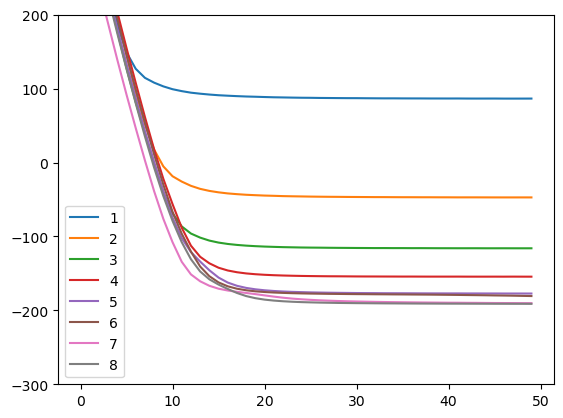

In [19]:
fig,ax = utils.plot_losses(losses, degrees = degrees, y_lim=[-300, 200])
fig.savefig('agt_polar_' + str(num_points_in_one_traj) + '.svg')

In [21]:
utils.save_result(folder_dir =log_root_dir, file_name='result_summary', result=result)